In [1]:

from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import random
import numpy as np
import transformers
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.ops import MLP

def seed_everything(seed: int, device: str):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device == "cuda":
        torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    transformers.set_seed(seed)

/anaconda/envs/protein_functions/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:


class ProTCL(nn.Module):
    def __init__(
        self,
        protein_embedding_dim=1100,
        label_embedding_dim=1024,
        latent_dim=1024,
        label_encoder=None,
        sequence_encoder=None,
        train_label_encoder=False,
        train_sequence_encoder=False,
        output_mlp_hidden_dim_scale_factor=1,
        output_mlp_num_layers=2,
        output_neuron_bias=None,
        output_mlp_normalization = 'BN',
        label_batch_size_limit=float("inf"),
        sequence_batch_size_limit=float("inf"),
        ln_before_concat = False
    ):
        super().__init__()

        # Training options
        train_label_encoder, train_sequence_encoder = train_label_encoder, train_sequence_encoder

        # Encoders
        label_encoder, sequence_encoder = label_encoder, sequence_encoder

        # Batch size limits
        label_batch_size_limit,  sequence_batch_size_limit = label_batch_size_limit, sequence_batch_size_limit

        # Projection heads
        self.W_p = nn.Linear(protein_embedding_dim, latent_dim, bias=False)
        self.W_l = nn.Linear(label_embedding_dim, latent_dim, bias=False)

        self.LN1 = nn.LayerNorm(latent_dim)
        self.LN2 = nn.LayerNorm(latent_dim)

        # TODO: This could change. Currently keeping latent dim.
        self.output_layer = get_mlp(
            input_dim=latent_dim*2,
            hidden_dim=int(round(output_mlp_hidden_dim_scale_factor*latent_dim)),
            num_layers=output_mlp_num_layers,
            output_neuron_bias=output_neuron_bias,
            normalization=output_mlp_normalization
        )

        self.ln_before_concat = ln_before_concat

    def _get_joint_embeddings(self, P_e, L_e):
        num_sequences = P_e.shape[0]
        num_labels = L_e.shape[0]
        sequence_embedding_dim = P_e.shape[1]
        label_embedding_dim = L_e.shape[1]

        # Use broadcasting so we don't have to expand the tensor dimensions
        joint_embeddings = torch.cat([
            P_e[:, None, :].expand(
                num_sequences, num_labels, sequence_embedding_dim),
            L_e[None, :, :].expand(
                num_sequences, num_labels, label_embedding_dim)
        ], dim=2).reshape(-1, sequence_embedding_dim + label_embedding_dim)

        return joint_embeddings, num_sequences, num_labels

    def forward(
        self,
        sequence_onehots=None,
        sequence_embeddings=None,
        sequence_lengths=None,
        tokenized_labels=None,
        label_embeddings=None
    ):
        """
        Forward pass of the model.
        Returns a representation of the similarity between each sequence and each label.
        args:
            sequence_onehots (optional): Tensor of one-hot encoded protein sequences.
            sequence_embeddings (optional): Tensor of pre-trained sequence embeddings.
            sequence_lengths (optional): Tensor of sequence lengths.
            tokenized_labels (optional): List of tokenized label sequences.
            label_embeddings (optional): Tensor of pre-trained label embeddings.
        """

        # If label embeddings are provided and we're not training the laebel encoder, use them. Otherwise, compute them.
        
        L_f = label_embeddings

        # If sequence embeddings are provided and we're not training the sequence encoder, use them. Otherwise, compute them.
        
        P_f = sequence_embeddings

        # Project protein and label embeddings to common latent space.

        P_e = self.W_p(P_f)
        L_e = self.W_l(L_f)

        if self.ln_before_concat:
            P_e = self.LN1(P_e)
            L_e = self.LN2(L_e)

        # Get concatenated embeddings, representing all possible combinations of protein and label embeddings
        # (number proteins * number labels by latent_dim*2)
        joint_embeddings, num_sequences, num_labels = self._get_joint_embeddings(
            P_e, L_e)

        # Feed through MLP to get logits (which represent similarities)
        logits = self.output_layer(joint_embeddings)

        # Reshape for loss function
        logits = logits.reshape(num_sequences, num_labels)
        
        
        return logits


def get_mlp(input_dim,
            hidden_dim,
            num_layers,
            normalization = 'BN',
            output_neuron_bias=None):
    """
    Creates a variable length MLP with ReLU activations.
    """
    layers = []

    add_hidden_layers_bias =  normalization !='BN'
   
    if normalization == 'BN':
        n = nn.BatchNorm1d
    elif normalization =='LN':
        n = nn.LayerNorm
    else:
        n = nn.Identity

    for idx in range(num_layers):
        if idx ==0:
            layers.append(nn.Linear(input_dim, hidden_dim,bias=add_hidden_layers_bias))
        else:
            layers.append(nn.Linear(hidden_dim, hidden_dim,bias=add_hidden_layers_bias))
 
        layers.append(n([hidden_dim]))
 
        layers.append(nn.ReLU())
       
    output_neuron = nn.Linear(hidden_dim, 1)
    if output_neuron_bias is not None:
        # Set the bias of the final linear layer
        output_neuron.bias.data.fill_(output_neuron_bias)
    layers.append(output_neuron)
    return nn.Sequential(*layers)


  0%|          | 0/100 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [00:00<00:00, 150.62it/s]

epoch 0, loss 0.724
epoch 1, loss 0.702
epoch 2, loss 0.711
epoch 3, loss 0.693
epoch 4, loss 0.682
epoch 5, loss 0.686
epoch 6, loss 0.686
epoch 7, loss 0.678
epoch 8, loss 0.670
epoch 9, loss 0.667
epoch 10, loss 0.668
epoch 11, loss 0.666
epoch 12, loss 0.660
epoch 13, loss 0.655
epoch 14, loss 0.652
epoch 15, loss 0.652
epoch 16, loss 0.649
epoch 17, loss 0.644
epoch 18, loss 0.640
epoch 19, loss 0.637
epoch 20, loss 0.635
epoch 21, loss 0.632
epoch 22, loss 0.627
epoch 23, loss 0.623
epoch 24, loss 0.620
epoch 25, loss 0.617
epoch 26, loss 0.613
epoch 27, loss 0.608
epoch 28, loss 0.605
epoch 29, loss 0.601
epoch 30, loss 0.597


 48%|████▊     | 48/100 [00:00<00:00, 153.02it/s]

epoch 31, loss 0.592
epoch 32, loss 0.588
epoch 33, loss 0.584
epoch 34, loss 0.579
epoch 35, loss 0.574
epoch 36, loss 0.569
epoch 37, loss 0.564
epoch 38, loss 0.558
epoch 39, loss 0.553
epoch 40, loss 0.548
epoch 41, loss 0.542
epoch 42, loss 0.536
epoch 43, loss 0.531
epoch 44, loss 0.524
epoch 45, loss 0.518
epoch 46, loss 0.512
epoch 47, loss 0.505
epoch 48, loss 0.499
epoch 49, loss 0.492
epoch 50, loss 0.485
epoch 51, loss 0.478
epoch 52, loss 0.471
epoch 53, loss 0.464
epoch 54, loss 0.456
epoch 55, loss 0.449
epoch 56, loss 0.441
epoch 57, loss 0.434
epoch 58, loss 0.426
epoch 59, loss 0.418
epoch 60, loss 0.410
epoch 61, loss 0.402


 80%|████████  | 80/100 [00:00<00:00, 153.17it/s]

epoch 62, loss 0.394
epoch 63, loss 0.386
epoch 64, loss 0.378
epoch 65, loss 0.370
epoch 66, loss 0.361
epoch 67, loss 0.353
epoch 68, loss 0.345
epoch 69, loss 0.337
epoch 70, loss 0.328
epoch 71, loss 0.320
epoch 72, loss 0.312
epoch 73, loss 0.304
epoch 74, loss 0.295
epoch 75, loss 0.287
epoch 76, loss 0.280
epoch 77, loss 0.273
epoch 78, loss 0.268
epoch 79, loss 0.263
epoch 80, loss 0.254
epoch 81, loss 0.244
epoch 82, loss 0.240
epoch 83, loss 0.235
epoch 84, loss 0.226
epoch 85, loss 0.221
epoch 86, loss 0.217
epoch 87, loss 0.209
epoch 88, loss 0.204
epoch 89, loss 0.201
epoch 90, loss 0.194
epoch 91, loss 0.188
epoch 92, loss 0.185
epoch 93, loss 0.179


100%|██████████| 100/100 [00:00<00:00, 153.00it/s]


epoch 94, loss 0.174
epoch 95, loss 0.170
epoch 96, loss 0.166
epoch 97, loss 0.161
epoch 98, loss 0.157
epoch 99, loss 0.153


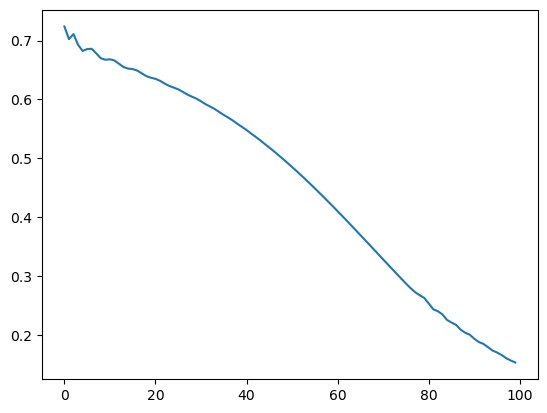

In [32]:
seed_everything(42,'cuda')
#TODO: REMOVE THIS
device = 'cuda'

dummy_seq_embs = torch.load('../../seq_emb_test.pt')
dummy_label_embs = torch.load('../../label_emb_test.pt')
#dummy_labels = torch.load('../label_multihots_test.pt')


num_labels = 100

NUM_EPOCHS = 100
gradient_accumulation_steps=1
clip_value=1
LR = 1e-5
#dummy_seq_embs = torch.rand((38,1100),device=device)
#dummy_label_embs = torch.rand((num_labels,1100),device=device)
dummy_labels = (torch.rand((38,num_labels),device=device)>=0.5).long()


#dummy_seq_embs = (dummy_seq_embs - dummy_seq_embs.mean(axis=0))/dummy_seq_embs.std(axis=0)
#dummy_label_embs = (dummy_label_embs - dummy_label_embs.mean(axis=0))/dummy_label_embs.std(axis=0)

model = ProTCL(
        protein_embedding_dim=dummy_seq_embs.shape[1],
        label_embedding_dim=dummy_label_embs.shape[1],
        latent_dim=1024,
        output_mlp_num_layers=4,
        output_mlp_hidden_dim_scale_factor=2,
        output_mlp_normalization='LN',
        ln_before_concat=True

    ).to(device)
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model.train()



scaler = GradScaler()
training_step=0
losses = []
all_joint_embeddings = []
accuracies = []
for epoch in tqdm(range(NUM_EPOCHS)):
    
    
    training_step+=1
    correct = 0
    with autocast():
        logits = model(sequence_embeddings=dummy_seq_embs,label_embeddings=dummy_label_embs)

        # Compute loss, normalized by the number of gradient accumulation steps
        loss = criterion(logits, dummy_labels.float())  / \
            gradient_accumulation_steps

    
    accuracies.append((((torch.sigmoid(logits)>0.5)*1==dummy_labels)*1.0).mean().item())
   
    # Backward pass with mixed precision
    scaler.scale(loss).backward()

    # Gradient accumulation every GRADIENT_ACCUMULATION_STEPS
    if (training_step % gradient_accumulation_steps == 0):
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=clip_value)
        
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
                
        print("epoch {}, loss {:.3f}".format(epoch, loss.item()))
        losses.append(loss.item())

    
plt.plot(losses)
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

 38%|███▊      | 38/100 [00:00<00:00, 187.09it/s]

epoch 0, loss 0.705
epoch 1, loss 0.776
epoch 2, loss 0.616
epoch 3, loss 0.564
epoch 4, loss 0.512
epoch 5, loss 0.485
epoch 6, loss 0.437
epoch 7, loss 0.411
epoch 8, loss 0.383
epoch 9, loss 0.345
epoch 10, loss 0.321
epoch 11, loss 0.293
epoch 12, loss 0.261
epoch 13, loss 0.240
epoch 14, loss 0.213
epoch 15, loss 0.190
epoch 16, loss 0.170
epoch 17, loss 0.149
epoch 18, loss 0.135
epoch 19, loss 0.118
epoch 20, loss 0.109
epoch 21, loss 0.100
epoch 22, loss 0.094
epoch 23, loss 0.079
epoch 24, loss 0.071
epoch 25, loss 0.069
epoch 26, loss 0.063
epoch 27, loss 0.054
epoch 28, loss 0.049
epoch 29, loss 0.049
epoch 30, loss 0.043
epoch 31, loss 0.040
epoch 32, loss 0.037
epoch 33, loss 0.034
epoch 34, loss 0.033
epoch 35, loss 0.030
epoch 36, loss 0.029
epoch 37, loss 0.027


 77%|███████▋  | 77/100 [00:00<00:00, 189.05it/s]

epoch 38, loss 0.026
epoch 39, loss 0.023
epoch 40, loss 0.023
epoch 41, loss 0.022
epoch 42, loss 0.020
epoch 43, loss 0.019
epoch 44, loss 0.021
epoch 45, loss 0.030
epoch 46, loss 0.033
epoch 47, loss 0.023
epoch 48, loss 0.027
epoch 49, loss 0.018
epoch 50, loss 0.021
epoch 51, loss 0.022
epoch 52, loss 0.017
epoch 53, loss 0.019
epoch 54, loss 0.015
epoch 55, loss 0.015
epoch 56, loss 0.015
epoch 57, loss 0.013
epoch 58, loss 0.013
epoch 59, loss 0.012
epoch 60, loss 0.012
epoch 61, loss 0.011
epoch 62, loss 0.010
epoch 63, loss 0.010
epoch 64, loss 0.009
epoch 65, loss 0.009
epoch 66, loss 0.008
epoch 67, loss 0.008
epoch 68, loss 0.008
epoch 69, loss 0.008
epoch 70, loss 0.007
epoch 71, loss 0.007
epoch 72, loss 0.006
epoch 73, loss 0.006
epoch 74, loss 0.006
epoch 75, loss 0.005
epoch 76, loss 0.005


100%|██████████| 100/100 [00:00<00:00, 187.72it/s]


epoch 77, loss 0.005
epoch 78, loss 0.005
epoch 79, loss 0.004
epoch 80, loss 0.004
epoch 81, loss 0.004
epoch 82, loss 0.004
epoch 83, loss 0.004
epoch 84, loss 0.003
epoch 85, loss 0.003
epoch 86, loss 0.003
epoch 87, loss 0.003
epoch 88, loss 0.003
epoch 89, loss 0.003
epoch 90, loss 0.002
epoch 91, loss 0.002
epoch 92, loss 0.002
epoch 93, loss 0.002
epoch 94, loss 0.002
epoch 95, loss 0.002
epoch 96, loss 0.002
epoch 97, loss 0.002
epoch 98, loss 0.002
epoch 99, loss 0.002


 44%|████▍     | 44/100 [00:00<00:00, 216.08it/s]

epoch 0, loss 0.693
epoch 1, loss 0.692
epoch 2, loss 0.691
epoch 3, loss 0.688
epoch 4, loss 0.687
epoch 5, loss 0.685
epoch 6, loss 0.682
epoch 7, loss 0.678
epoch 8, loss 0.675
epoch 9, loss 0.673
epoch 10, loss 0.678
epoch 11, loss 0.664
epoch 12, loss 0.670
epoch 13, loss 0.658
epoch 14, loss 0.663
epoch 15, loss 0.651
epoch 16, loss 0.654
epoch 17, loss 0.642
epoch 18, loss 0.644
epoch 19, loss 0.629
epoch 20, loss 0.632
epoch 21, loss 0.619
epoch 22, loss 0.608
epoch 23, loss 0.612
epoch 24, loss 0.598
epoch 25, loss 0.579
epoch 26, loss 0.581
epoch 27, loss 0.587
epoch 28, loss 0.563
epoch 29, loss 0.540
epoch 30, loss 0.549
epoch 31, loss 0.549
epoch 32, loss 0.516
epoch 33, loss 0.501
epoch 34, loss 0.515
epoch 35, loss 0.517
epoch 36, loss 0.478
epoch 37, loss 0.455
epoch 38, loss 0.471
epoch 39, loss 0.479
epoch 40, loss 0.444
epoch 41, loss 0.410
epoch 42, loss 0.420
epoch 43, loss 0.442


 88%|████████▊ | 88/100 [00:00<00:00, 216.25it/s]

epoch 44, loss 0.419
epoch 45, loss 0.371
epoch 46, loss 0.364
epoch 47, loss 0.389
epoch 48, loss 0.392
epoch 49, loss 0.346
epoch 50, loss 0.313
epoch 51, loss 0.327
epoch 52, loss 0.349
epoch 53, loss 0.336
epoch 54, loss 0.287
epoch 55, loss 0.264
epoch 56, loss 0.283
epoch 57, loss 0.303
epoch 58, loss 0.288
epoch 59, loss 0.241
epoch 60, loss 0.218
epoch 61, loss 0.236
epoch 62, loss 0.255
epoch 63, loss 0.245
epoch 64, loss 0.203
epoch 65, loss 0.177
epoch 66, loss 0.190
epoch 67, loss 0.207
epoch 68, loss 0.204
epoch 69, loss 0.171
epoch 70, loss 0.144
epoch 71, loss 0.149
epoch 72, loss 0.165
epoch 73, loss 0.166
epoch 74, loss 0.143
epoch 75, loss 0.119
epoch 76, loss 0.116
epoch 77, loss 0.127
epoch 78, loss 0.132
epoch 79, loss 0.119
epoch 80, loss 0.100
epoch 81, loss 0.093
epoch 82, loss 0.098
epoch 83, loss 0.104
epoch 84, loss 0.099
epoch 85, loss 0.087
epoch 86, loss 0.077
epoch 87, loss 0.076


100%|██████████| 100/100 [00:00<00:00, 216.14it/s]


epoch 88, loss 0.080
epoch 89, loss 0.082
epoch 90, loss 0.079
epoch 91, loss 0.071
epoch 92, loss 0.064
epoch 93, loss 0.062
epoch 94, loss 0.064
epoch 95, loss 0.066
epoch 96, loss 0.067
epoch 97, loss 0.065
epoch 98, loss 0.060
epoch 99, loss 0.055


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0, loss 0.693
epoch 1, loss 0.692
epoch 2, loss 0.691
epoch 3, loss 0.689
epoch 4, loss 0.687
epoch 5, loss 0.684
epoch 6, loss 0.682
epoch 7, loss 0.679
epoch 8, loss 0.677
epoch 9, loss 0.671
epoch 10, loss 0.667
epoch 11, loss 0.665


 44%|████▍     | 44/100 [00:00<00:00, 217.48it/s]

epoch 12, loss 0.657
epoch 13, loss 0.651
epoch 14, loss 0.650
epoch 15, loss 0.637
epoch 16, loss 0.663
epoch 17, loss 0.659
epoch 18, loss 0.617
epoch 19, loss 0.650
epoch 20, loss 0.640
epoch 21, loss 0.598
epoch 22, loss 0.596
epoch 23, loss 0.588
epoch 24, loss 0.577
epoch 25, loss 0.597
epoch 26, loss 0.572
epoch 27, loss 0.598
epoch 28, loss 0.612
epoch 29, loss 0.551
epoch 30, loss 0.648
epoch 31, loss 0.693
epoch 32, loss 0.573
epoch 33, loss 0.582
epoch 34, loss 0.665
epoch 35, loss 0.585
epoch 36, loss 0.543
epoch 37, loss 0.571
epoch 38, loss 0.515
epoch 39, loss 0.620
epoch 40, loss 0.679
epoch 41, loss 0.557
epoch 42, loss 0.540
epoch 43, loss 0.609
epoch 44, loss 0.535
epoch 45, loss 0.540
epoch 46, loss 0.580
epoch 47, loss 0.501
epoch 48, loss 0.578
epoch 49, loss 0.656
epoch 50, loss 0.549
epoch 51, loss 0.496
epoch 52, loss 0.535
epoch 53, loss 0.478
epoch 54, loss 0.570
epoch 55, loss 0.638


 88%|████████▊ | 88/100 [00:00<00:00, 217.08it/s]

epoch 56, loss 0.526
epoch 57, loss 0.493
epoch 58, loss 0.544
epoch 59, loss 0.479
epoch 60, loss 0.536
epoch 61, loss 0.595
epoch 62, loss 0.497
epoch 63, loss 0.497
epoch 64, loss 0.553
epoch 65, loss 0.476
epoch 66, loss 0.506
epoch 67, loss 0.563
epoch 68, loss 0.478
epoch 69, loss 0.499
epoch 70, loss 0.557
epoch 71, loss 0.475
epoch 72, loss 0.491
epoch 73, loss 0.544
epoch 74, loss 0.465
epoch 75, loss 0.496
epoch 76, loss 0.555
epoch 77, loss 0.471
epoch 78, loss 0.479
epoch 79, loss 0.531
epoch 80, loss 0.456
epoch 81, loss 0.491
epoch 82, loss 0.550
epoch 83, loss 0.465
epoch 84, loss 0.471
epoch 85, loss 0.523
epoch 86, loss 0.449
epoch 87, loss 0.484


100%|██████████| 100/100 [00:00<00:00, 217.28it/s]

epoch 88, loss 0.542
epoch 89, loss 0.458
epoch 90, loss 0.465
epoch 91, loss 0.516
epoch 92, loss 0.443
epoch 93, loss 0.477
epoch 94, loss 0.534
epoch 95, loss 0.451
epoch 96, loss 0.459
epoch 97, loss 0.511
epoch 98, loss 0.438
epoch 99, loss 0.470


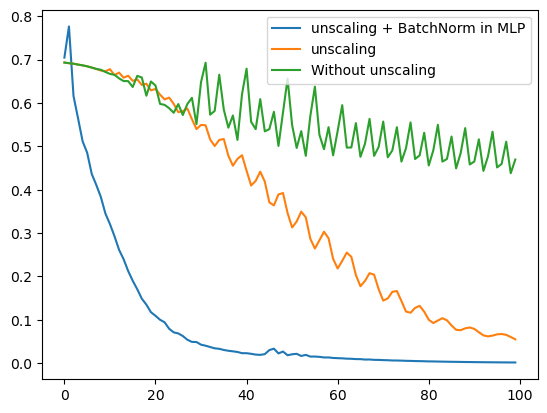

Bad pipe message: %s [b'0\x1d\x8f~C\x8b\xb4\x13j\xb6W\xcbY\xa0\xe2S\xd2\x89 l\xb4T\x8e\xfa)\x1f\x17\xfea8\x89[j\xfe5\xe9\xb6tC<bn\xf3\x849[k\x0c\x1c\x86\x81\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00']
Bad pipe message: %s [b'\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 =\x82$\xb8\x82\x0c!`\xbc\xcd\xf3E1\xe9/F\xcc\xe8\xd3K\xbb\x10\x88i*Gq\xe9\xd7z\xc5b']
Bad pipe message: %s [b"\x87\xfbr\xe2Eve2\x1d\xc9\xdbSe\xcc\x9dx\xce\xee\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x

In [ ]:
seed_everything(42,'cuda')
#TODO: REMOVE THIS
device = 'cuda'

dummy_seq_embs = torch.load('../../seq_emb_test.pt')
dummy_label_embs = torch.load('../../label_emb_test.pt')
#dummy_labels = torch.load('../label_multihots_test.pt')


num_labels =100

NUM_EPOCHS = 100
gradient_accumulation_steps=1
clip_value=1
output_mlp_num_layers = 4
output_mlp_hidden_dim_scale_factor = 2
LR = 1e-4
#dummy_seq_embs = torch.rand((38,1100),device=device)
#dummy_label_embs = torch.rand((num_labels,1100),device=device)
dummy_labels = (torch.rand((38,num_labels),device=device)>=0.5).long()


#dummy_seq_embs = (dummy_seq_embs - dummy_seq_embs.mean(axis=0))/dummy_seq_embs.std(axis=0)
#dummy_label_embs = (dummy_label_embs - dummy_label_embs.mean(axis=0))/dummy_label_embs.std(axis=0)

model = ProTCL(
        protein_embedding_dim=dummy_seq_embs.shape[1],
        label_embedding_dim=dummy_label_embs.shape[1],
        latent_dim=1024,
        output_mlp_num_layers=output_mlp_num_layers,
        output_mlp_hidden_dim_scale_factor=output_mlp_hidden_dim_scale_factor,
        output_mlp_normalization='BN'
    ).to(device)
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model.train()
scaler = GradScaler()
training_step=0
losses = []
all_joint_embeddings = []
accuracies = []
for epoch in tqdm(range(NUM_EPOCHS)):
    
    
    training_step+=1
    correct = 0
    with autocast():
        logits = model(sequence_embeddings=dummy_seq_embs,label_embeddings=dummy_label_embs)

        # Compute loss, normalized by the number of gradient accumulation steps
        loss = criterion(logits, dummy_labels.float())  / \
            gradient_accumulation_steps

    
    accuracies.append((((torch.sigmoid(logits)>0.5)*1==dummy_labels)*1.0).mean().item())
   
    # Backward pass with mixed precision
    scaler.scale(loss).backward()

    # Gradient accumulation every GRADIENT_ACCUMULATION_STEPS
    if (training_step % gradient_accumulation_steps == 0):
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=clip_value)
        
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
                
        print("epoch {}, loss {:.3f}".format(epoch, loss.item()))
        losses.append(loss.item())

    
plt.plot(losses,label='unscaling + BatchNorm in MLP')


model = ProTCL(
        protein_embedding_dim=dummy_seq_embs.shape[1],
        label_embedding_dim=dummy_label_embs.shape[1],
        latent_dim=1024,
        output_mlp_num_layers=output_mlp_num_layers,
        output_mlp_hidden_dim_scale_factor=output_mlp_hidden_dim_scale_factor,
        output_mlp_normalization=None
    ).to(device)
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model.train()
scaler = GradScaler()
training_step=0
losses = []
all_joint_embeddings = []
accuracies = []
for epoch in tqdm(range(NUM_EPOCHS)):
    
    
    training_step+=1
    correct = 0
    with autocast():
        logits = model(sequence_embeddings=dummy_seq_embs,label_embeddings=dummy_label_embs)

        # Compute loss, normalized by the number of gradient accumulation steps
        loss = criterion(logits, dummy_labels.float())  / \
            gradient_accumulation_steps

    
    accuracies.append((((torch.sigmoid(logits)>0.5)*1==dummy_labels)*1.0).mean().item())
   
    # Backward pass with mixed precision
    scaler.scale(loss).backward()

    # Gradient accumulation every GRADIENT_ACCUMULATION_STEPS
    if (training_step % gradient_accumulation_steps == 0):
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=clip_value)
        
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
                
        print("epoch {}, loss {:.3f}".format(epoch, loss.item()))
        losses.append(loss.item())

    
plt.plot(losses,label='unscaling')


model = ProTCL(
        protein_embedding_dim=dummy_seq_embs.shape[1],
        label_embedding_dim=dummy_label_embs.shape[1],
        latent_dim=1024,
        output_mlp_num_layers=output_mlp_num_layers,
        output_mlp_hidden_dim_scale_factor=output_mlp_hidden_dim_scale_factor,
        output_mlp_normalization=None
    ).to(device)
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model.train()
scaler = GradScaler()
training_step=0
losses = []
all_joint_embeddings = []
accuracies = []
for epoch in tqdm(range(NUM_EPOCHS)):
    
    
    training_step+=1
    correct = 0
    with autocast():
        logits = model(sequence_embeddings=dummy_seq_embs,label_embeddings=dummy_label_embs)

        # Compute loss, normalized by the number of gradient accumulation steps
        loss = criterion(logits, dummy_labels.float())  / \
            gradient_accumulation_steps

    
    accuracies.append((((torch.sigmoid(logits)>0.5)*1==dummy_labels)*1.0).mean().item())
   
    # Backward pass with mixed precision
    scaler.scale(loss).backward()

    # Gradient accumulation every GRADIENT_ACCUMULATION_STEPS
    if (training_step % gradient_accumulation_steps == 0):
        
        # Unscales the gradients of optimizer's assigned params in-place
        #scaler.unscale_(optimizer)
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=clip_value)
        
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
                
        print("epoch {}, loss {:.3f}".format(epoch, loss.item()))
        losses.append(loss.item())

    
plt.plot(losses,label='Without unscaling')
plt.legend()
plt.show()

